In [1]:
import numpy as np
import h3
import pandas as pd
import os
import geopandas as gpd
import re
import shapely.wkb as swkb
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import osmnx
from shapely.ops import unary_union
from geopy.geocoders import Nominatim
import geopy
from shapely.geometry import Point
from geopy.distance import geodesic

In [17]:
# def load_raw_files():  
#     path = r'C:\Users\gcich\OneDrive\Pulpit\Magister\Semestr1\AnalizaDanychWNOZ\Projekt2\data\external'
#     files = os.listdir(path)
#     pattern = '.+parquet'
#     source_files = []
#     for file in files:
#         if re.match(pattern, file):
#             df = pd.read_parquet(os.path.join(path,file))
#             source_files.append(df)
#     return source_files

# def extract_features(series):
#     dict_of_lists = {}
#     for d in series:
#         for key, value in d.items():
#             dict_of_lists.setdefault(key, []).append(value)
            
#     return pd.DataFrame(data=dict_of_lists)

# def create_gdf(df):
#     df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
#     gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
#     gdf = gdf.set_crs('EPSG:4326')
#     return gdf

def load_raw_files():  
    try:
        path = r'C:\Users\gcich\OneDrive\Pulpit\Magister\Semestr1\AnalizaDanychWNOZ\Projekt2\data\external'
        files = os.listdir(path)
        pattern = '.+parquet'
        source_files = []
        for file in files:
            if re.match(pattern, file):
                df = pd.read_parquet(os.path.join(path,file))
                source_files.append(df)
        return source_files
    except Exception as e:
        raise Exception(f"Error in load_and_transform.load_raw_files: {e}")


def extract_features(series):
    try:
        dict_of_lists = {}
        for d in series:
            for key, value in d.items():
                dict_of_lists.setdefault(key, []).append(value)
            
        return pd.DataFrame(data=dict_of_lists)
    except Exception as e:
        raise Exception(f"Error in load_and_transform.extract_features: {e}")

def create_gdf(df,epsg):
    try:
        df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
        gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
        gdf = gdf.set_crs(epsg=epsg)
        return gdf
    except Exception as e:
        raise Exception(f"Error in load_and_transform.create_gdf: {e}")

In [41]:
data = load_raw_files()
df_ams = data[0]
df_krk = data[1]

gdf_ams = create_gdf(df_ams,4326)
gdf_krk = create_gdf(df_krk,4326)
gdf_ams.head(5)


,id,geometry,tags.abandoned:railway,tags.access,tags.access:conditional,tags.agricultural,tags.alt_name,tags.architect,tags.asphalt,tags.bicycle,...,tags.turn:lanes:forward,tags.two_sided,tags.usage,tags.vehicle,tags.wheelchair,tags.width,tags.wikidata,tags.wikimedia_commons,tags.wikipedia,tags.zone:traffic
0,4264947,"LINESTRING (4.92236 52.36544, 4.92237 52.36543...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,4270806,"LINESTRING (4.93089 52.36596, 4.93090 52.36585...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,4305753,"LINESTRING (4.86787 52.32198, 4.86787 52.32192)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,6.00,None,None,None,None
3,4363637,"LINESTRING (4.91538 52.37115, 4.91544 52.37118...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,2.40,Q19292742,None,None,None
4,4364612,"LINESTRING (4.92291 52.37384, 4.92291 52.37389...",None,yes,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [34]:
def get_boundary_coord(row, func, which):
    x, y = zip(*row.coords)
    return func(x) if which == 'x' else func(y)


buffer = 0.01
max_x = max(df_ams['geometry'].apply(lambda row: get_boundary_coord(row, max, 'x'))) + buffer
min_x = min(df_ams['geometry'].apply(lambda row: get_boundary_coord(row, min, 'x'))) - buffer
max_y = max(df_ams['geometry'].apply(lambda row: get_boundary_coord(row, max, 'y'))) + buffer
min_y = min(df_ams['geometry'].apply(lambda row: get_boundary_coord(row, min, 'y'))) - buffer
print(max_x, min_x, max_y, min_y)

5.1127658 4.7228487 52.441972799999995 52.268887500000005


In [35]:
geo = {
    'type': 'Polygon',
    'coordinates': [
        [
            [min_x, min_y],
            [min_x, max_y],
            [max_x, max_y],
            [max_x, min_y]
        ]
    ]
}

hexes = h3.polyfill(geo, 8)


In [36]:
hex_polygons = [Polygon(h3.h3_to_geo_boundary(h3_index)) for h3_index in hexes]

# Create a GeoDataFrame with these hex polygons
gdf_ams_pol = gpd.GeoDataFrame(geometry=hex_polygons)
gdf_ams_pol = gdf_ams_pol.set_crs('EPSG:4326')

# # Plot the hexagons
# fig, ax = plt.subplots(figsize = (10,10))
# gdf_ams_pol.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
# gdf_ams.plot(ax = ax, linewidth = 1, edgecolor = 'blue')
# # Set plot title and labels
# ax.set_title('H3 Hexagons plot for Amsterdam')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.axis('square')
# ax.set_ylim([min_y,max_y])
# ax.set_xlim([min_x,max_x])

In [37]:
def create_h3_grid(df, epsg=4326):
    try:
        buffer = 0.01
        max_x = max(df['geometry'].apply(lambda row: get_boundary_coord(row, max, 'x'))) + buffer
        min_x = min(df['geometry'].apply(lambda row: get_boundary_coord(row, min, 'x'))) - buffer
        max_y = max(df['geometry'].apply(lambda row: get_boundary_coord(row, max, 'y'))) + buffer
        min_y = min(df['geometry'].apply(lambda row: get_boundary_coord(row, min, 'y'))) - buffer
        
        geo = {
            'type': 'Polygon',
            'coordinates': [
                [
                    [min_x, min_y],
                    [min_x, max_y],
                    [max_x, max_y],
                    [max_x, min_y]
                ]
            ]
        }

        hexes = h3.polyfill(geo, 8)
        hex_polygons = [Polygon(h3.h3_to_geo_boundary(h3_index)) for h3_index in hexes]

        gdf_pol = gpd.GeoDataFrame(geometry=hex_polygons)
        gdf_pol = gdf_pol.set_crs(epsg=epsg)
        return gdf_pol, (max_y, min_y,max_x, min_x)
    except Exception as e:
        raise Exception(f"Error in load_and_transform.create_h3_grid: {e}")

# def create_h3_grid(df, epsg=4326):
#     buffer = 0.01
#     max_x = max(df['geometry'].apply(lambda row: get_boundary_coord(row, max, 'x'))) + buffer
#     min_x = min(df['geometry'].apply(lambda row: get_boundary_coord(row, min, 'x'))) - buffer
#     max_y = max(df['geometry'].apply(lambda row: get_boundary_coord(row, max, 'y'))) + buffer
#     min_y = min(df['geometry'].apply(lambda row: get_boundary_coord(row, min, 'y'))) - buffer
    
#     geo = {
#         'type': 'Polygon',
#         'coordinates': [
#             [
#                 [min_x, min_y],
#                 [min_x, max_y],
#                 [max_x, max_y],
#                 [max_x, min_y]
#             ]
#         ]
#     }

#     hexes = h3.polyfill(geo, 8)
#     hex_polygons = [Polygon(h3.h3_to_geo_boundary(h3_index)) for h3_index in hexes]

#     gdf_pol = gpd.GeoDataFrame(geometry=hex_polygons)
#     gdf_pol = gdf_pol.set_crs(epsg=epsg)
#     return gdf_pol, (max_y, min_y,max_x, min_x)

In [42]:
gdf_krk_pol, bbox_krk = create_h3_grid(gdf_krk)
gdf_ams_pol, bbox_ams = create_h3_grid(gdf_ams)

Pobranie danych dotyczących granic miasta

In [43]:


ams_area = osmnx.geocode_to_gdf("Amsterdam")
krk_area = osmnx.geocode_to_gdf("Kraków")


ams_area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((4.72878 52.40071, 4.75607 52.3...",52.431064,52.278174,5.079162,4.728778,169672125,relation,271110,52.37308,4.892453,boundary,administrative,16,0.726813,city,Amsterdam,"Amsterdam, North Holland, Netherlands"


In [28]:
EPSG = 4326
AMS_PROJ_EPSG = 28992
KRK_PROJ_EPSG = 2180

#  LOAD BIKEPATHS DATA AND CONVERT IT TO GDF
df_ams,df_krk = load_raw_files()

gdf_ams = create_gdf(df_ams,EPSG)
gdf_krk = create_gdf(df_krk,EPSG)

# CREATE H3 GRID AND GET ITS MAX/MIN LON/LAT
gdf_ams_pol, bbox_ams = create_h3_grid(gdf_krk)
gdf_krk_pol, bbox_krk = create_h3_grid(gdf_krk)
print('H3 grids created')

# GET GDF WITH POLYGON OF CITY AREA
ams_area = osmnx.geocode_to_gdf("Amsterdam")
krk_area = osmnx.geocode_to_gdf("Kraków")

# CROP GRID TO CITY BOUNDARIES AND CALCULATE SUMMED LENGTH OF BIKEPATHS
# gdf_ams_pol = lt.crop_grid(gdf_ams_pol, gdf_ams, ams_area, AMS_PROJ_EPSG)
# gdf_krk_pol = lt.crop_grid(gdf_krk_pol, gdf_krk, krk_area, KRK_PROJ_EPSG)
# print('H3 grids cropped')

H3 grids created


In [44]:
gdf_ams_proj = gdf_ams.to_crs(epsg=28992)
gdf_ams_pol = gdf_ams_pol.to_crs(epsg=28992)
ams_area_proj = ams_area.to_crs(epsg=28992)
gdf_ams_pol['bike_path_length'] = 0.0
gdf_ams_pol['within_city'] = False

for i, polygon in gdf_ams_pol.iterrows():
    clipped = gdf_ams_proj.clip(polygon.geometry)
    within_city = polygon.geometry.intersects(ams_area_proj.geometry)
    gdf_ams_pol.loc[i,'bike_path_length'] = clipped.length.sum()
    gdf_ams_pol.loc[i,'within_city'] = within_city[0]

gdf_ams_pol = gdf_ams_pol[(gdf_ams_pol['within_city'] == True) | (gdf_ams_pol['bike_path_length'] > 0)]
gdf_ams_pol = gdf_ams_pol.to_crs(epsg=4326)
gdf_ams_pol

,geometry,bike_path_length,within_city
1,"POLYGON ((4.90752 52.34483, 4.91151 52.34603, ...",2939.177288,True
3,"POLYGON ((4.93936 52.31850, 4.94334 52.31970, ...",797.232569,True
9,"POLYGON ((4.94915 52.37334, 4.95313 52.37454, ...",0.000000,True
10,"POLYGON ((4.83807 52.37979, 4.84205 52.38099, ...",2691.746933,True
13,"POLYGON ((4.81624 52.32132, 4.82024 52.32252, ...",135.972570,False
...,...,...,...
1404,"POLYGON ((4.92257 52.34138, 4.92655 52.34259, ...",1710.546229,True
1405,"POLYGON ((5.03271 52.39852, 5.03668 52.39972, ...",0.000000,True
1406,"POLYGON ((4.88147 52.38886, 4.88546 52.39006, ...",2048.924902,True
1411,"POLYGON ((4.76994 52.42712, 4.77393 52.42832, ...",0.000000,True


Text(60.972222222222214, 0.5, 'Latitude')

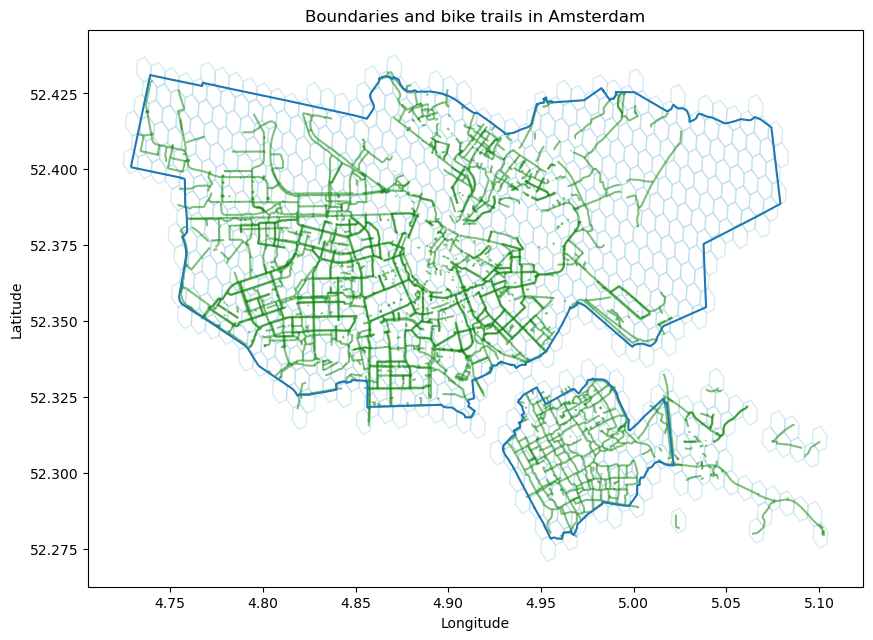

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
gdf_ams.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_pol.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
ams_area['geometry'].boundary.plot(ax=ax)
# Set plot title and labels
ax.set_title('Boundaries and bike trails in Amsterdam')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [15]:
def crop_grid(hex_gdf, bikepath_gdf, area_gdf, epsg):
    bikepath_gdf_proj = bikepath_gdf.to_crs(epsg=epsg)
    hex_gdf = hex_gdf.to_crs(epsg=epsg)
    area_gdf_proj = area_gdf.to_crs(epsg=epsg)
    hex_gdf['bike_path_length'] = 0.0
    hex_gdf['within_city'] = False

    for i, polygon in hex_gdf.iterrows():
        clipped = bikepath_gdf_proj.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(area_gdf_proj.geometry)
        hex_gdf.loc[i,'bike_path_length'] = clipped.length.sum()
        hex_gdf.loc[i,'within_city'] = within_city[0]

    hex_gdf = hex_gdf[(hex_gdf['within_city'] == True) | (hex_gdf['bike_path_length'] > 0)]
    hex_gdf = hex_gdf.to_crs(epsg=4326)
    del hex_gdf['within_city']
    return hex_gdf

Text(60.972222222222214, 0.5, 'Latitude')

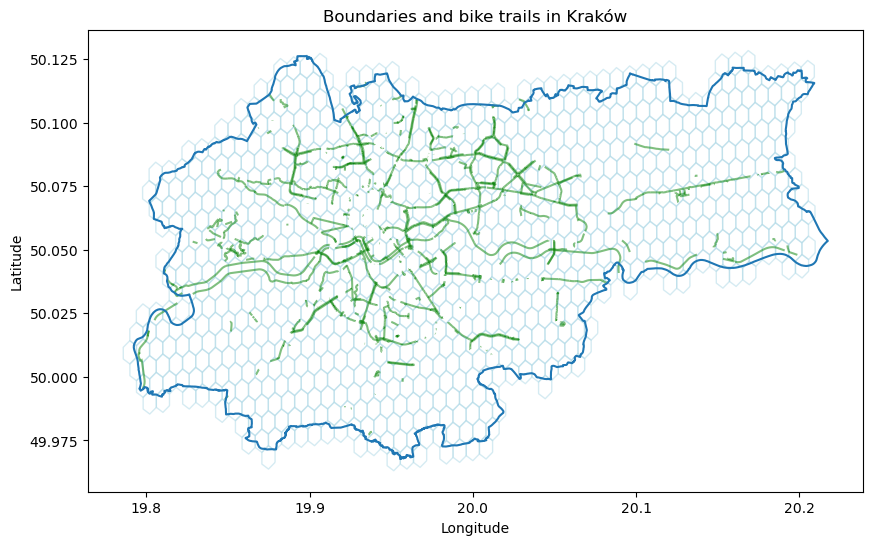

In [16]:
gdf_krk_pol = crop_grid(gdf_krk_pol, gdf_krk, krk_area, 2180)

fig, ax = plt.subplots(figsize = (10,10))
gdf_krk.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_pol.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
krk_area['geometry'].boundary.plot(ax=ax)
# Set plot title and labels
ax.set_title('Boundaries and bike trails in Kraków')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [17]:
G_roads = osmnx.graph_from_bbox(bbox=(max_y, min_y,max_x, min_x), network_type='drive')
G_walks = osmnx.graph_from_bbox(bbox=(max_y, min_y,max_x, min_x), network_type='walk')

# Convert the road network to a GeoDataFrame of edges
gdf_walks = osmnx.graph_to_gdfs(G_walks, nodes=False)
gdf_roads = osmnx.graph_to_gdfs(G_roads, nodes=False)

gdf_roads.head(5)

osmid       highway maxspeed  \
u        v          key                                                         
6316199  46379627   0    [38297120, 7372610, 38297119]   residential       30   
         46389218   0                          7372614   residential       30   
25596477 4489285115 0                         23289375  unclassified       30   
25658579 1334338691 0           [118689924, 118689927]   residential       30   
26203121 2311089467 0               [7373692, 7382053]   residential       30   

                         oneway       reversed   length bridge  \
u        v          key                                          
6316199  46379627   0     False          False   42.497    yes   
         46389218   0      True          False  225.577    NaN   
25596477 4489285115 0     False          False   81.156    NaN   
25658579 1334338691 0     False  [False, True]   37.997    NaN   
26203121 2311089467 0      True          False  193.316    NaN   

                                                                    name  \
u        v          key                                                    
6316199  46379627   0         [Joes Kloppenburgbrug, Oude Spiegelstraat]   
         46389218   0                                             Singel   
25596477 4489285115 0                                 Nieuwe Herengracht   
25658579 1334338691 0                                       Roomtuintjes   
26203121 2311089467 0    [Jacob van Lennepkade, Nicolaas Beetsplantsoen]   

                                                                  geometry  \
u        v          key                                                      
6316199  46379627   0    LINESTRING (4.88840 52.37017, 4.88827 52.37018...   
         46389218   0    LINESTRING (4.88840 52.37017, 4.88873 52.37195...   
25596477 4489285115 0    LINESTRING (4.90610 52.36700, 4.90612 52.36702...   
25658579 1334338691 0    LINESTRING (4.93042 52.36454, 4.92999 52.36445...   
26203121 2311089467 0    LINESTRING (4.86524 52.36416, 4.86550 52.36376...   

                        lanes width  ref access junction tunnel est_width area  
u        v          key                                                         
6316199  46379627   0     NaN   NaN  NaN    NaN      NaN    NaN       NaN  NaN  
         46389218   0     NaN   NaN  NaN    NaN      NaN    NaN       NaN  NaN  
25596477 4489285115 0     NaN   NaN  NaN    NaN      NaN    NaN       NaN  NaN  
25658579 1334338691 0     NaN   NaN  NaN    NaN      NaN    NaN       NaN  NaN  
26203121 2311089467 0       1     4  NaN    NaN      NaN    NaN       NaN  NaN

In [18]:
gdf_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x).unique()

gdf_roads_main = gdf_roads[gdf_roads['highway'].isin(['secondary', 'primary', 'tertiary', 'busway',
       'motorway_link', 'motorway'])]

gdf_roads_main.head(3)

,,,osmid,highway,maxspeed,oneway,reversed,length,bridge,name,geometry,lanes,width,ref,access,junction,tunnel,est_width,area
u,v,key,,,,,,,,,,,,,,,,,
27561854,46311177,0,147577798,secondary,30,True,False,217.778,NaN,Amstelveenseweg,"LINESTRING (4.85468 52.35639, 4.85486 52.35605...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29529317,46360122,0,"[7045705, 258138666, 738258604, 738258605, 115...",primary,30,True,False,374.502,NaN,Zeeburgerdijk,"LINESTRING (4.93228 52.36611, 4.93202 52.36610...",NaN,NaN,S100,NaN,NaN,NaN,NaN,NaN
30741325,306596544,0,"[155304272, 155304271, 7390927]",tertiary,50,False,False,26.836,yes,Aalsmeerderweg,"LINESTRING (4.76793 52.27019, 4.76806 52.27023...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
hex_area = unary_union(gdf_ams_pol.geometry)
gdf_roads_main_clipped = gdf_roads_main.geometry.clip(hex_area)
gdf_walks_clipped = gdf_walks.geometry.clip(hex_area)

In [20]:
gdf_ams_pol = gdf_ams_pol.to_crs(epsg=28992)
gdf_roads_main_clipped_proj = gdf_roads_main_clipped.to_crs(epsg=28992)
gdf_walks_clipped_proj = gdf_walks_clipped.to_crs(epsg=28992)
gdf_ams_pol['main_roads_length'] = 0.0
gdf_ams_pol['walks_length'] = 0.0
for i, polygon in gdf_ams_pol.iterrows():

    clipped_r = gdf_roads_main_clipped_proj.clip(polygon.geometry)
    clipped_w = gdf_walks_clipped_proj.clip(polygon.geometry)
    gdf_ams_pol.loc[i,'main_roads_length'] = clipped_r.length.sum()
    gdf_ams_pol.loc[i,'walks_length'] = clipped_w.length.sum()

gdf_ams_pol = gdf_ams_pol.to_crs(epsg=4326)
gdf_ams_pol

,geometry,bike_path_length,within_city,main_roads_length,walks_length
0,"POLYGON ((5.02649 52.30487, 5.03047 52.30607, ...",717.254294,False,1054.224860,0.000000
2,"POLYGON ((4.73983 52.43403, 4.74382 52.43523, ...",0.000000,True,1056.723381,1471.580695
3,"POLYGON ((5.08482 52.31051, 5.08880 52.31171, ...",436.176588,False,0.000000,1975.249926
5,"POLYGON ((4.90578 52.36426, 4.90976 52.36546, ...",3611.597090,True,4275.317157,25476.403652
8,"POLYGON ((5.02430 52.35610, 5.02828 52.35730, ...",0.000000,True,0.000000,1952.010381
...,...,...,...,...,...
1411,"POLYGON ((4.87608 52.33935, 4.88007 52.34055, ...",2960.189710,True,3689.066955,15636.272224
1412,"POLYGON ((4.76179 52.35285, 4.76578 52.35405, ...",803.393652,True,2513.140645,15553.503096
1413,"POLYGON ((5.01945 52.38256, 5.02343 52.38376, ...",0.000000,True,0.000000,0.000000
1414,"POLYGON ((4.83768 52.41159, 4.84167 52.41279, ...",145.138157,True,375.468832,0.000000


Text(60.972222222222214, 0.5, 'Latitude')

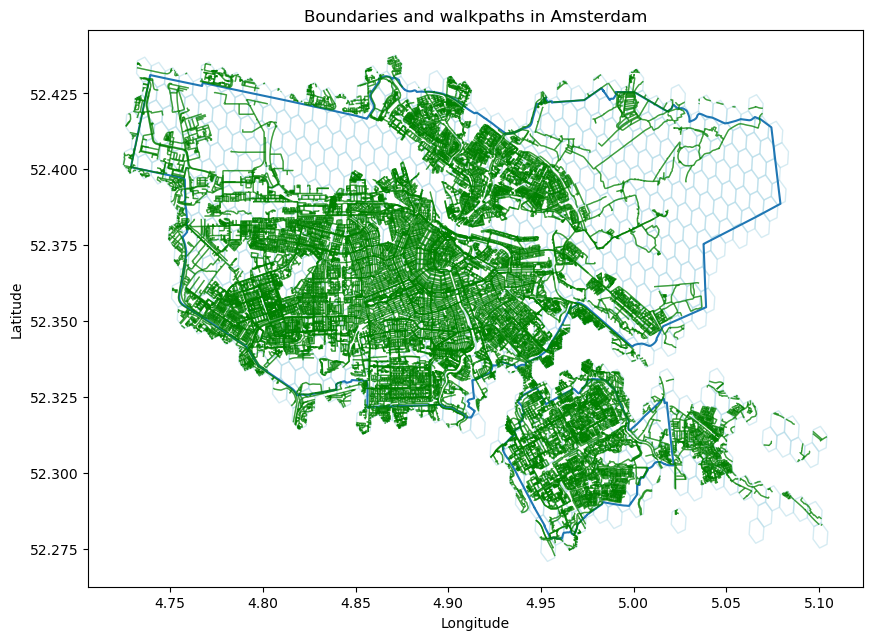

In [21]:

fig, ax = plt.subplots(figsize = (10,10))
ams_area['geometry'].boundary.plot(ax=ax)
# gdf_roads_main_clipped.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5,linewidth = 1)
gdf_walks_clipped.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5,linewidth = 1)
gdf_ams_pol.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
ax.set_title('Boundaries and walkpaths in Amsterdam')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(60.972222222222214, 0.5, 'Latitude')

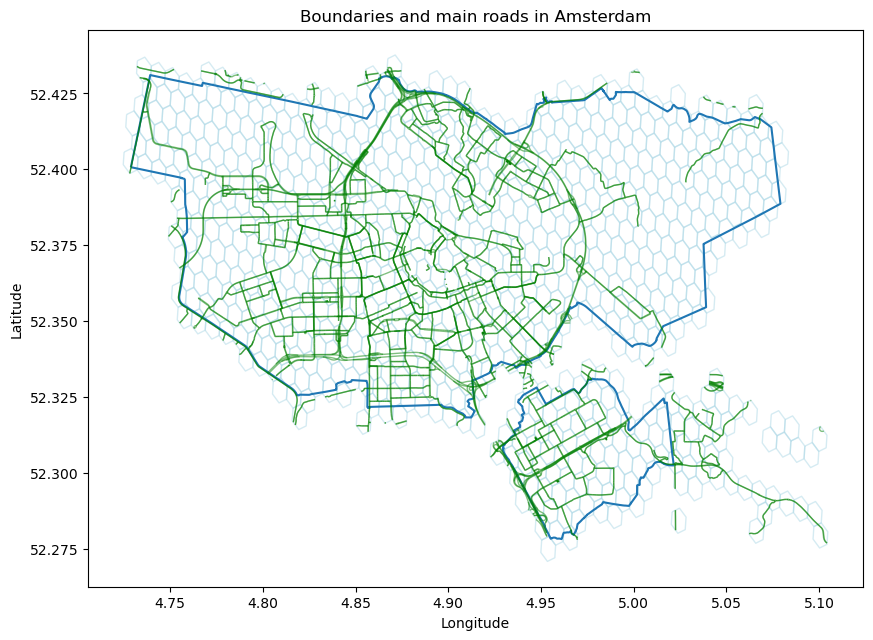

In [22]:

fig, ax = plt.subplots(figsize = (10,10))
ams_area['geometry'].boundary.plot(ax=ax)
gdf_roads_main_clipped.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5,linewidth = 1)
gdf_ams_pol.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
ax.set_title('Boundaries and main roads in Amsterdam')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [31]:

def get_roads_and_walks_length_by_hex(hex_gdf, bbox, hex_area, epsg):
    try:
        G_roads = osmnx.graph_from_bbox(bbox=bbox, network_type='drive')
        G_walks = osmnx.graph_from_bbox(bbox=bbox, network_type='walk')

        # Convert the road network to a GeoDataFrame of edges
        gdf_walks = osmnx.graph_to_gdfs(G_walks, nodes=False)
        gdf_roads = osmnx.graph_to_gdfs(G_roads, nodes=False)
        
        gdf_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x).unique()
        gdf_roads_main = gdf_roads[gdf_roads['highway'].isin(['secondary', 'primary', 'tertiary', 'busway',
            'motorway_link', 'motorway'])]
        
        gdf_roads_main_clipped = gdf_roads_main.geometry.clip(hex_area)
        gdf_walks_clipped = gdf_walks.geometry.clip(hex_area)
        
        old_epsg = hex_gdf.crs.to_epsg()
        hex_gdf = hex_gdf.to_crs(epsg=epsg)
        gdf_roads_main_clipped_proj = gdf_roads_main_clipped.to_crs(epsg=epsg)
        gdf_walks_clipped_proj = gdf_walks_clipped.to_crs(epsg=epsg)
        hex_gdf['main_roads_length'] = 0.0
        hex_gdf['walks_length'] = 0.0
        
        for i, polygon in hex_gdf.iterrows():
            clipped_r = gdf_roads_main_clipped_proj.clip(polygon.geometry)
            clipped_w = gdf_walks_clipped_proj.clip(polygon.geometry)
            hex_gdf.loc[i,'main_roads_length'] = clipped_r.length.sum()
            hex_gdf.loc[i,'walks_length'] = clipped_w.length.sum()

        hex_gdf = hex_gdf.to_crs(epsg=old_epsg)
        return hex_gdf
    except Exception as e:
        raise Exception(f"Error in build_fetures.get_roads_and_walks_length_by_hex: {e}")

In [32]:
hex_area_krk = unary_union(gdf_krk_pol.geometry)
gdf_krk_pol = get_roads_and_walks_length_by_hex(gdf_krk_pol,bbox_krk, hex_area_krk, 2180)

gdf_krk_pol

,geometry,bike_path_length,main_roads_length,walks_length
0,"POLYGON ((19.87029 50.06219, 19.86627 50.05956...",0.000000,752.703999,18753.952325
1,"POLYGON ((20.15267 50.09935, 20.14865 50.09671...",0.000000,0.000000,2941.228226
2,"POLYGON ((19.96302 50.07674, 19.95900 50.07411...",0.000000,729.247169,37622.406036
3,"POLYGON ((19.99145 50.04459, 19.98743 50.04196...",768.523420,804.387714,32194.829552
4,"POLYGON ((19.99952 50.04525, 19.99550 50.04262...",0.000000,0.000000,19476.079253
...,...,...,...,...
1199,"POLYGON ((19.95117 50.02747, 19.94715 50.02484...",1091.508211,3011.931160,37758.754319
1200,"POLYGON ((19.84622 50.03263, 19.84220 50.03001...",628.425423,0.000000,5435.112273
1203,"POLYGON ((20.04804 50.03544, 20.04402 50.03281...",742.089076,3039.222193,28170.735626
1204,"POLYGON ((19.97093 50.10498, 19.96691 50.10235...",1566.891034,1695.978262,19633.563664


In [25]:
def get_city_center_gdf(city_name):
    try:
         
        geolocator = Nominatim(user_agent="my-app")
        location = geolocator.geocode(city_name)
        if isinstance(location, geopy.location.Location):
            center_gdf = gpd.GeoDataFrame(geometry=[Point(location.longitude, location.latitude)],crs=4326) 
            return center_gdf
        
        print(f"Failed to get {city_name} center.")
        return None
        
    except Exception as e:
        print(f"Failed to get {city_name} center: {e}")
        return None


In [26]:
gdf_center_ams = get_city_center_gdf('Amsterdam')
gdf_center_krk = get_city_center_gdf('Krakow')
gdf_center_ams

,geometry
0,POINT (4.89245 52.37308)


Text(1031.4267676767674, 0.5, 'Latitude')

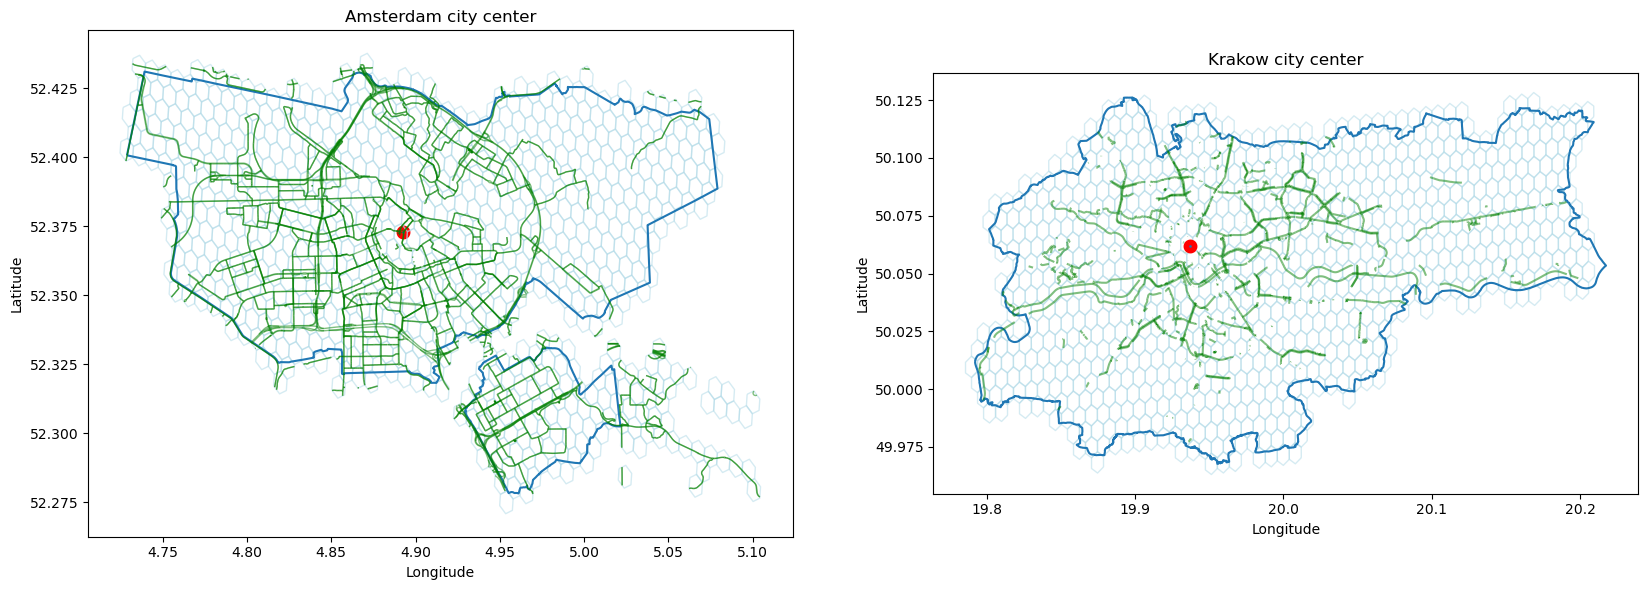

In [27]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
ams_area['geometry'].boundary.plot(ax=ax[0])
gdf_roads_main_clipped.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5,linewidth = 1)
gdf_center_ams.plot(ax=ax[0], linewidth=4, edgecolor='red')
gdf_ams_pol.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
ax[0].set_title('Amsterdam city center')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

krk_area['geometry'].boundary.plot(ax=ax[1])

gdf_krk_pol.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
gdf_center_krk.plot(ax=ax[1], linewidth=4, edgecolor='red')
gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
ax[1].set_title('Krakow city center')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

In [28]:
def get_hex_dist_to_city_center(hex_gdf, center_gdf, epsg):
    old_epsg = hex_gdf.crs.to_epsg()
    center_gdf_proj = center_gdf.to_crs(epsg=epsg)
    hex_gdf = hex_gdf.to_crs(epsg=epsg)

    hex_gdf['dist_to_city_center[m]'] = hex_gdf.geometry.centroid.distance(center_gdf_proj.iloc[0,0])
    hex_gdf = hex_gdf.to_crs(epsg=old_epsg)
    return hex_gdf

In [29]:
gdf_ams_pol = get_hex_dist_to_city_center(gdf_ams_pol, gdf_center_ams, 28992)
gdf_ams_pol

,geometry,bike_path_length,within_city,main_roads_length,walks_length,dist_to_city_center[m]
0,"POLYGON ((5.02649 52.30487, 5.03047 52.30607, ...",717.254294,False,1054.224860,0.000000,12270.153915
2,"POLYGON ((4.73983 52.43403, 4.74382 52.43523, ...",0.000000,True,1056.723381,1471.580695,12026.379443
3,"POLYGON ((5.08482 52.31051, 5.08880 52.31171, ...",436.176588,False,0.000000,1975.249926,15210.169980
5,"POLYGON ((4.90578 52.36426, 4.90976 52.36546, ...",3611.597090,True,4275.317157,25476.403652,1739.453707
8,"POLYGON ((5.02430 52.35610, 5.02828 52.35730, ...",0.000000,True,0.000000,1952.010381,9483.691513
...,...,...,...,...,...,...
1411,"POLYGON ((4.87608 52.33935, 4.88007 52.34055, ...",2960.189710,True,3689.066955,15636.272224,4171.114083
1412,"POLYGON ((4.76179 52.35285, 4.76578 52.35405, ...",803.393652,True,2513.140645,15553.503096,9034.708953
1413,"POLYGON ((5.01945 52.38256, 5.02343 52.38376, ...",0.000000,True,0.000000,0.000000,8918.238975
1414,"POLYGON ((4.83768 52.41159, 4.84167 52.41279, ...",145.138157,True,375.468832,0.000000,5276.485961
